In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import geopandas as gpd
import shapely
import matplotlib.cm as color_map
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV

from scipy.spatial import distance_matrix

import folium

#plt.rcParams['figure.figsize']=(12,12)
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")


## Load data and clean data

Data is gathered from the website: http://www.airbezen.be/ and saved in a json. Here you see the measurements on a map:

<img src="http://www.airbezen.be/page-7/files/stacks-image-f1fbc0f.jpg" style="max-height:400px;"><br>

From each measurement, we extract the following information:

- longitude
- latitude
- post_code
- quality: the measured air quality
- info: extra info

We convert lat/lon coordinates to Lambert coordinates, to have units on a square grid in meters.

On the legend of the map on the website, we see that some measurements are colored grey. The legend says *'Dichtbij sporen, mogelijk verhoogd'*. This is reflected by the info in the json, where for some measurement it says: *'Plantje dicht bij sporen (trein of tram): de meetwaarde is mogelijk verhoogd door spoorverkeer.'* As the authors are clearly doubting these values (otherwhise they would not color them gray, we drop these measurements.



In [2]:
data_curieuzeneuzen = pd.read_json('data_curieuzeneuzen/data.json')
print('{} datapoints'.format(len(data_curieuzeneuzen)))
data_curieuzeneuzen['geometry'] = data_curieuzeneuzen['geometry'].apply(lambda x: shapely.geometry.Point(x['coordinates']))
data_curieuzeneuzen_gdp = gpd.GeoDataFrame(data_curieuzeneuzen, crs={'init': 'epsg:4326'}, geometry='geometry')
data_curieuzeneuzen_gdp['no2cat'] = data_curieuzeneuzen_gdp['properties'].apply(lambda x: x['no2cat'])
data_curieuzeneuzen_gdp['no2cat'] = data_curieuzeneuzen_gdp['no2cat'].astype(float)
data_curieuzeneuzen_gdp.head()

19843 datapoints


,geometry,properties,tile,type,no2cat
0,POINT (4.194374084472656 50.74471123849256),"{'postal': 1500, 'no2cat': 3}","{'x': 131, 'z': 8, 'y': 86}",Feature,3
1,POINT (4.218406677246094 50.74319048706403),"{'postal': 1500, 'no2cat': 4}","{'x': 131, 'z': 8, 'y': 86}",Feature,4
2,POINT (4.21600341796875 50.73971429832358),"{'postal': 1500, 'no2cat': 3}","{'x': 131, 'z': 8, 'y': 86}",Feature,3
3,POINT (4.230766296386719 50.75340029914929),"{'postal': 1600, 'no2cat': 3}","{'x': 131, 'z': 8, 'y': 86}",Feature,3
4,POINT (4.2242431640625 50.74297323282792),"{'postal': 1500, 'no2cat': 4}","{'x': 131, 'z': 8, 'y': 86}",Feature,4


## Use a plane projection

In [8]:
data_curieuzeneuzen_gdp = data_curieuzeneuzen_gdp.to_crs(crs={'init' :'epsg:3857'})
data_curieuzeneuzen_gdp['x'] = data_curieuzeneuzen_gdp['geometry'].apply(lambda x: x.x)
data_curieuzeneuzen_gdp['y'] = data_curieuzeneuzen_gdp['geometry'].apply(lambda x: x.y)


## Demean the data

In [6]:
data_curieuzeneuzen_gdp['no2cat_demeaned'] = data_curieuzeneuzen_gdp['no2cat'] - data_curieuzeneuzen_gdp['no2cat'].mean()

## Reduce the size of the data by working only on the region Brussels Antwerp Leuven

In [9]:
data_curieuzeneuzen_gdp = data_curieuzeneuzen_gdp.loc[data_curieuzeneuzen_gdp['x'].between(400000, 600000),:]


## Exploratory plots

Text(0.5,1,'Raw data')

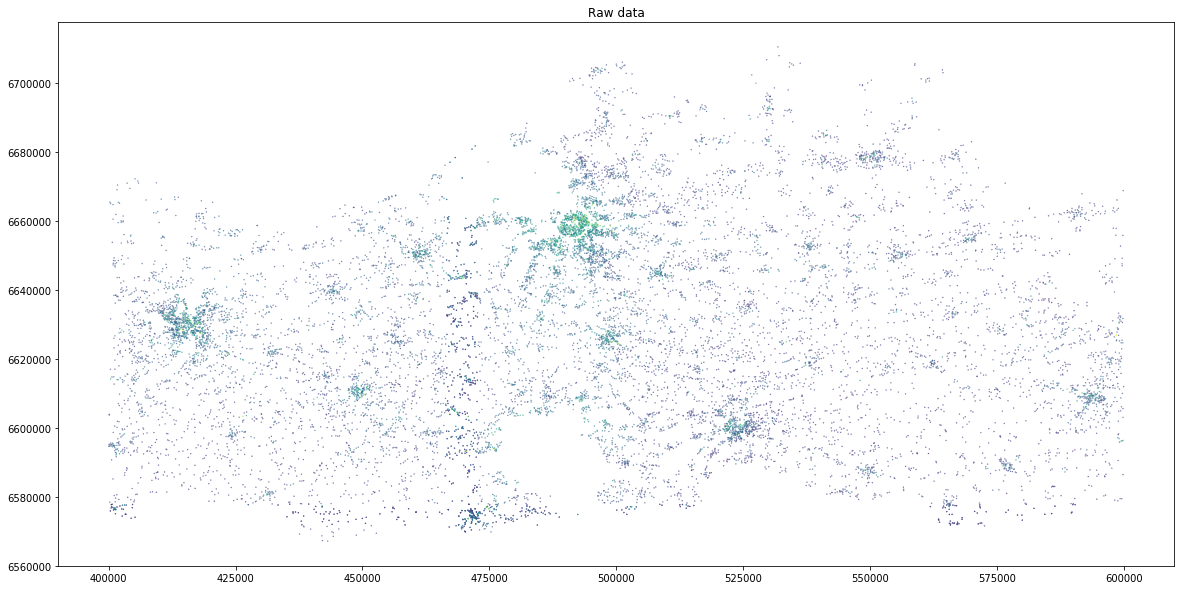

In [10]:

fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.scatter(x=data_curieuzeneuzen_gdp['x'], y=data_curieuzeneuzen_gdp['y'], c=data_curieuzeneuzen_gdp['no2cat'], s=0.1 )
ax.set_title('Raw data')

Text(0,0.5,'Count of measures')

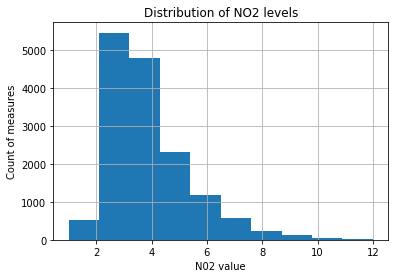

In [11]:
data_curieuzeneuzen_gdp['no2cat'].hist()
plt.title('Distribution of NO2 levels')
plt.xlabel('N02 value')
plt.ylabel('Count of measures')

## Do we see spatial correlation?

Does the squared difference between the measurements decreases if they are close to eachother? 

In [12]:
data_curieuzeneuzen_gdp = data_curieuzeneuzen_gdp.sample(frac=1)

In [14]:
# Takes quite a while...
distances_measurements = distance_matrix(data_curieuzeneuzen_gdp[['x', 'y']], data_curieuzeneuzen_gdp[['x', 'y']])

variogram_data = []

for i, row_i in enumerate(distances_measurements):
    if(i%10==0): print(i)
    if(i>300):break
    for j, distance in enumerate(distances_measurements[i]):
        if(distance<0.01): continue
        if(distance>5000): continue
        diff_squared = np.power(data_curieuzeneuzen_gdp.iloc[i, :]['no2cat_demeaned'] - data_curieuzeneuzen_gdp.iloc[j, :]['no2cat_demeaned'],2)
        temp_dict = {'i': i, 'j':j, 'diff': diff_squared, 'distance': distance}
        variogram_data.append(temp_dict)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


Text(0.5,1,'Variogram')

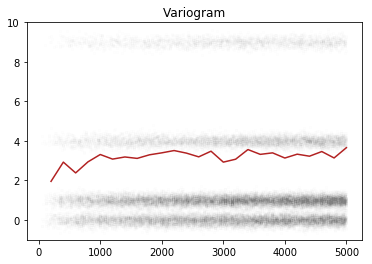

In [17]:
variogram_data = pd.DataFrame(variogram_data)
variogram_data['distance_rounded'] = np.round(variogram_data['distance']/200)*200
difference_binned = variogram_data.groupby('distance_rounded')['diff'].mean()
difference_binned = difference_binned.iloc[1:]
fig, ax = plt.subplots(1,1)
ax.plot(variogram_data['distance'], 
        variogram_data['diff'] + np.random.randn(len(variogram_data['diff']))/5,
        '.', alpha=0.005, color='grey')
ax.plot(difference_binned.index, difference_binned, color='firebrick', )
ax.set_ylim(-1,10)
ax.set_title('Variogram')

## Grid point sampler 

This is a helper function to sample gridpoints out of a polygon.

We use it to sample a grid out of the area covered by the airbezen measurements.

In [18]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step

In [19]:
convex_hull = shapely.geometry.MultiPoint(list(data_curieuzeneuzen_gdp.geometry)).convex_hull.buffer(1000)
sampler = RegularGridSampler(convex_hull, x_interval=2000, y_interval=2000)
sampler.perform_sampling()



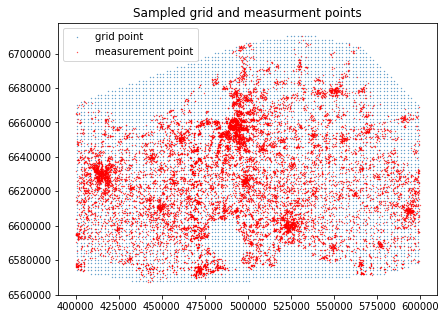

In [21]:
grid_points = sampler.get_spatial_df()
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(grid_points['x'], grid_points['y'],s=0.1, label='grid point')
ax.scatter(data_curieuzeneuzen_gdp['x'], data_curieuzeneuzen_gdp['y'], s=0.1, c='red', label='measurement point')
ax.set_title('Sampled grid and measurment points')
ax.set_aspect('equal')
ax.legend()

## Create a holdout test set

Gaussian processes is prone to overfitting, and so we protect us against overfitting by creating a leave out dataset.

In [23]:
air_df_test = data_curieuzeneuzen_gdp.sample(frac=0.1).copy()
print('Number of rows in test dataset: {}'.format(len(air_df_test)))
air_df_train = data_curieuzeneuzen_gdp.loc[~data_curieuzeneuzen_gdp.index.isin(air_df_test.index),:].copy()
print('Number of rows in train dataset: {}'.format(len(air_df_train)))


Number of rows in test dataset: 1528
Number of rows in train dataset: 13751


## Baseline estimator: use the mean as prediction

In [26]:
air_df_test['pred_1_baseline'] = air_df_train['no2cat_demeaned'].mean()

mse_baseline = mean_squared_error(y_true = air_df_test['no2cat_demeaned'], 
                   y_pred = air_df_test['pred_1_baseline'])

print('model with just the mean: MSE={:.3f}'.format(mse_baseline))

model with just the mean: MSE=1.844


## Gradient boosting model

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'n_estimators': [10, 20, 40, 80, 160, 320, 640], 
             'max_depth':[3]}

gbm_model = GradientBoostingRegressor(learning_rate=0.1)

gbm_grid = GridSearchCV(estimator=gbm_model, param_grid=param_grid, cv=3, verbose=1, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True,n_jobs=-1)

gbm_grid.fit(X=air_df_train[['x','y']], y=air_df_train['no2cat_demeaned'])


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 40, 80, 160, 320, 640], 'max_depth': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

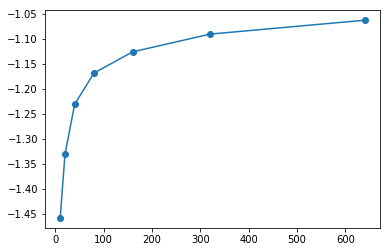

In [36]:
cv_results = pd.DataFrame(gbm_grid.cv_results_)
plt.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], 'o-')

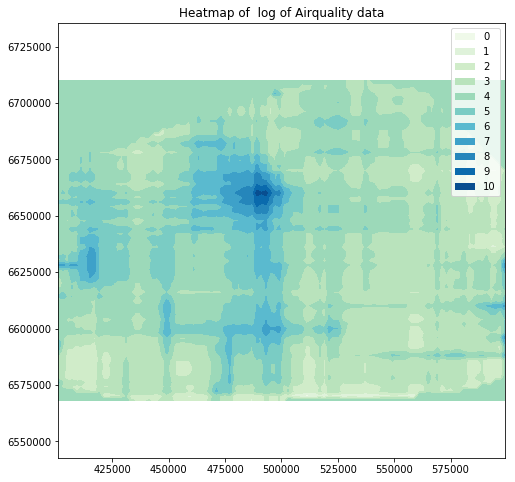

In [37]:
grid_points['pred_2_gbm'] = gbm_grid.best_estimator_.predict(grid_points[['x', 'y']])

temp_df = pd.DataFrame({'x' : grid_points['x'].values, 'y' : grid_points['y'].values, 'z' : 
                        grid_points['pred_2_gbm']})
temp_df = temp_df.pivot(index = 'y', columns = 'x', values = 'z').fillna(0)

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
contourplot = ax.contourf(np.unique(grid_points['x']), np.unique(grid_points['y']), temp_df.values, 10,cmap='GnBu')

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in contourplot.collections]

plt.legend(proxy, [str(i) for i in range(len(proxy))])

ax.set_title('Heatmap of  log of Airquality data')
#ax.plot(air_df_train['x'], air_df_train['y'], '.', color='black', alpha=0.5)
ax.axes.set_aspect('equal', 'datalim')



In [38]:
air_df_test['pred_2_gbm'] = gbm_grid.best_estimator_.predict(air_df_test[['x', 'y']])

mse_baseline = mean_squared_error(y_true = air_df_test['no2cat_demeaned'], 
                   y_pred = air_df_test['pred_2_gbm'])

print('model with just the mean: MSE={:.3f}'.format(mse_baseline))

model with just the mean: MSE=1.081


## Understanding the kernel parameters

We are going to build a model with Gaussian processes, which uses a kernel. We choose to use the squared exponential kernel. This is the formula that gives the correlation:

$$k_{\textrm{SE}}(x, x') = \sigma^2\exp\left(-\frac{(x - x')^2}{2\ell^2}\right)$$

This formula basically gives the modelled correlation between two measurements separated by a distance d. This correlation is:
- zero if the distance between the meausurments is very large
- $\sigma$ if the distance is zero.

The most important parameter is the bandwith $\ell$. ($\sigma$ is just a scaling factor). This is the parameter we will tune in order to get the best map. By visually inspecting the exploratory airbezen map, we make the assumption that measurements more than 5 kilometer from each other are not correlated. So that gives us an upperbound for $\ell$, all of the kernels should never have a correlation bigger than 0 if the distance between the measurements is larger than 5000m

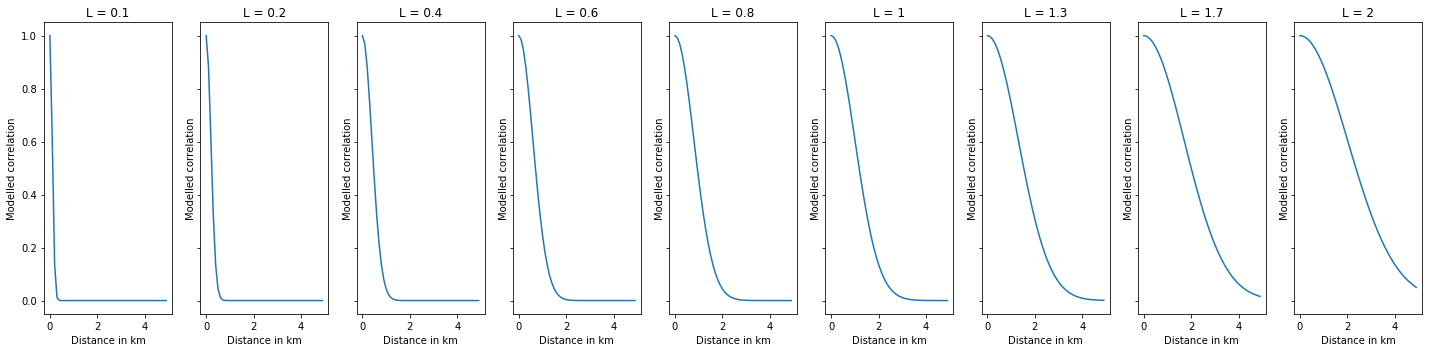

In [39]:
distances = np.arange(0, 5, step=0.1)

tuning_l = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.3, 1.7, 2]

fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 5), sharey=True)
row_index = 0
for i, l in enumerate(tuning_l):
    kernel_values = []
    for distance in distances:
        kernal_value = np.exp(-(distance**2) / (2*l**2))
        kernel_values.append(kernal_value)
    axes[i].plot(distances, kernel_values)
    axes[i].set_title('L = {}'.format(l))
    axes[i].set_xlabel('Distance in km')
    axes[i].set_ylabel('Modelled correlation')    
fig.tight_layout()  

## Gaussian Process Regressor

We implement Gaussian Process Regressor with the sklearn package. As discussed, we will need to tune the parameter $\ell$ of our squared exponential kernel. Take a look on the sklearn website for more information: http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html

The formula for Radial Basis Kernel is somewhat different that the one for squared exponential (although equivalent), which means we have somewhat different tuning parameters. 

Note that we work with units in km, instead of the Lambert coordinates in meters.

In [40]:
# Takes a long time
param_grid = {'alpha': [0.2,1, 2], 
             'kernel':[RBF(length_scale=4000, length_scale_bounds=(4000, 4000)),
                        RBF(length_scale=6000, length_scale_bounds=(6000, 6000)),
                      RBF(length_scale=8000, length_scale_bounds=(8000, 8000))]}

gpr = GaussianProcessRegressor(optimizer=None)

gpr_gs = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=3, verbose=1, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True,n_jobs=-1)

gpr_gs.fit(X=air_df_train[['x','y']], y=air_df_train['no2cat_demeaned'])


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 11.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False, optimizer=None,
             random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': [RBF(length_scale=4e+03), RBF(length_scale=6e+03), RBF(length_scale=8e+03)], 'alpha': [0.2, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

{'kernel': RBF(length_scale=4e+03), 'alpha': 1}


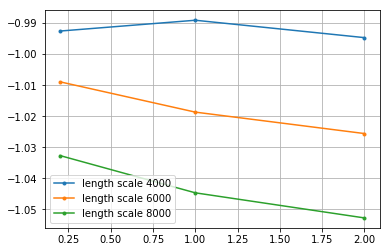

In [41]:
cv_results = pd.DataFrame(gpr_gs.cv_results_)
cv_results['param_length_scale'] = cv_results['param_kernel'].apply(lambda x: x.length_scale_bounds[1])

figure, ax = plt.subplots(ncols=1, nrows=1)
for length_scale in np.unique(cv_results['param_length_scale'].values):
    to_plot = cv_results.loc[cv_results['param_length_scale']==length_scale,['mean_test_score', 'param_alpha']]
    to_plot = to_plot.sort_values('param_alpha')
    ax.plot(to_plot['param_alpha'], to_plot['mean_test_score'],'.-', label='length scale {}'.format(length_scale))

    
ax.legend()
ax.grid()
print(gpr_gs.best_params_)

In [42]:
# Takes a long time
grid_points['gpr_prediction'], grid_points['gpr_std'] = gpr_gs.best_estimator_.predict(grid_points[['x', 'y']],return_std=True)

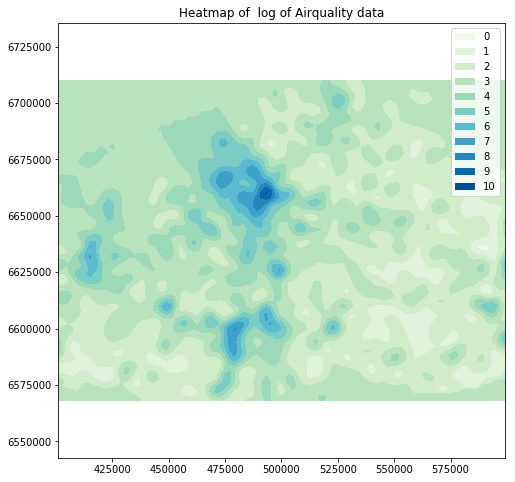

In [43]:
temp_df = pd.DataFrame({'x' : grid_points['x'].values, 'y' : grid_points['y'].values, 'z' : 
                        grid_points['gpr_prediction'],'std':grid_points['gpr_std']})
temp_df = temp_df.pivot(index = 'y', columns = 'x', values = 'z').fillna(0)

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
contourplot = ax.contourf(np.unique(grid_points['x']), np.unique(grid_points['y']), temp_df.values, 10,cmap='GnBu')

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in contourplot.collections]

plt.legend(proxy, [str(i) for i in range(len(proxy))])

ax.set_title('Heatmap of  log of Airquality data')
#ax.plot(air_df['x'], air_df['y'], '.', color='black', alpha=0.5)
ax.axes.set_aspect('equal', 'datalim')



## Investigate the incertainty of the predictions, use this to cut of gridpoints where we shouldn't predict

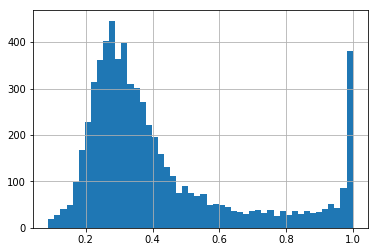

In [45]:
grid_points['gpr_std'].hist(bins=50)

## Folium plot sklearn Gaussian process


In [46]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = {'init':'epsg:3857'}
grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)


In [47]:
grid_points_pred_pivot = grid_points_gpd.pivot(values='gpr_prediction', columns='x', index='y').fillna(0)
grid_points_pred_pivot = grid_points_pred_pivot.loc[:,grid_points_pred_pivot.columns.sort_values(ascending=True)]
grid_points_pred_pivot = grid_points_pred_pivot.loc[grid_points_pred_pivot.index.sort_values(ascending=True),:]

In [82]:
#grid_points_pred_pivot

In [48]:
grid_points_pred_pivot_std = grid_points_gpd.pivot(values='gpr_std', columns='x', index='y').fillna(0)
grid_points_pred_pivot_std = grid_points_pred_pivot_std.loc[:,grid_points_pred_pivot_std.columns.sort_values(ascending=True)]
grid_points_pred_pivot_std = grid_points_pred_pivot_std.loc[grid_points_pred_pivot_std.index.sort_values(ascending=True),:]

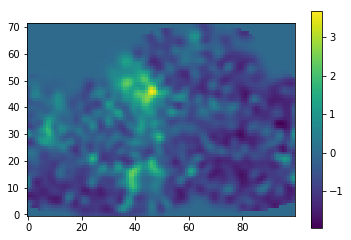

In [83]:
# Heatmap predictions
cnorm = plt.cm.viridis
norm=plt.Normalize(vmin=grid_points_pred_pivot.values.min(), vmax=grid_points_pred_pivot.values.max())
image = cnorm(norm(grid_points_pred_pivot.values))
plt.imshow(grid_points_pred_pivot,cmap=cnorm,origin='lower')
plt.colorbar()
# Create transparancy layer, cut of where we shouldn't predict
# This is outside the convex hull of the grid points, and on locations where the incertainty is too high
image[:,:,3] = (grid_points_pred_pivot_std  < 0.75) & (grid_points_pred_pivot_std!=0.000000)
from skimage.transform import resize
image_hq = resize(image, (image.shape[0]*20, image.shape[1]*20), mode='edge')

In [84]:
# Heatmap incertainty
#cnorm = plt.cm.viridis
#norm=plt.Normalize(vmin=grid_points_pred_pivot_std.values.min(), vmax=grid_points_pred_pivot_std.values.max())
#image = cnorm(norm(grid_points_pred_pivot_std.values))
#plt.imshow(grid_points_pred_pivot_std,cmap=cnorm,origin='lower')
#plt.colorbar()
# Create transparancy layer, cut of where we shouldn't predict
#image[:,:,3] = ~(grid_points_pred_pivot_std > 0.75)

#from skimage.transform import resize
#image_hq = resize(image, (image.shape[0]*20, image.shape[1]*20), mode='edge')

In [85]:
m = folium.Map(location=[grid_points_gpd['lat'].median(), grid_points_gpd['long'].median()],
               tiles='Stamen Toner', zoom_start=10)

folium.raster_layers.ImageOverlay(
    image=image_hq[:,:,:4],
    bounds=[[grid_points_gpd['lat'].min(), grid_points_gpd['long'].min()], 
            [grid_points_gpd['lat'].max(), grid_points_gpd['long'].max()]],
    mercator_project=True,
    opacity=0.75,
    origin='lower',
    interactive=True
).add_to(m)

m.save('kriging_curieuzeneuzen_data.html')

In [86]:
## MSE 
air_df_test['pred_3_kriging'] = gpr_gs.best_estimator_.predict(air_df_test[['x', 'y']] ,return_std=False)

mse_gp = mean_squared_error(y_true = air_df_test['no2cat_demeaned'], 
                   y_pred = air_df_test['pred_3_kriging'])

print('MSE Gaussian process: {:.3f}'.format(mse_gp))

MSE Gaussian process: 0.948


# The end

### Bonus: Kriging 1D data, daily weight measurements

In [191]:
data = pd.read_csv('WeightDiary.csv')
data = data.iloc[2:,:]


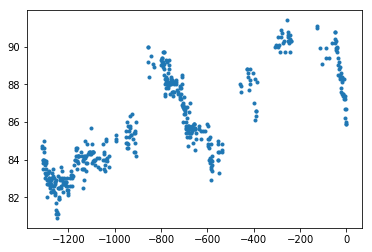

In [192]:
data['date'] = pd.to_datetime(data['units'])

basedate = pd.Timestamp('2018-03-14')
data['date_num'] = data.apply(lambda x: (x['date'] - basedate).days, axis=1)
data['kg_norm'] = data['kg'] - data['kg'].mean()
plt.plot(data['date_num'], data['kg'], '.')

In [193]:
param_grid = {'alpha': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1,2], 
             'kernel':[RBF(length_scale=20, length_scale_bounds=(20, 20)),
                      RBF(length_scale=30, length_scale_bounds=(30, 30)),
                      RBF(length_scale=40, length_scale_bounds=(40, 40)),
                      RBF(length_scale=50, length_scale_bounds=(50, 50))]}

gpr = GaussianProcessRegressor(optimizer=None)

gpr_gs = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=3, verbose=1, 
                      scoring='neg_mean_absolute_error',
                      return_train_score=True,n_jobs=-1)

gpr_gs.fit(X=data[['date_num']], y=data['kg_norm'])


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False, optimizer=None,
             random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': [RBF(length_scale=20), RBF(length_scale=30), RBF(length_scale=40), RBF(length_scale=50)], 'alpha': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

{'kernel': RBF(length_scale=50), 'alpha': 0.02}


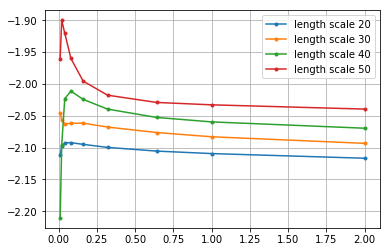

In [194]:
cv_results = pd.DataFrame(gpr_gs.cv_results_)
cv_results['param_length_scale'] = cv_results['param_kernel'].apply(lambda x: x.length_scale_bounds[1])

figure, ax = plt.subplots(ncols=1, nrows=1)
for length_scale in np.unique(cv_results['param_length_scale'].values):
    to_plot = cv_results.loc[cv_results['param_length_scale']==length_scale,['mean_test_score', 'param_alpha']]
    to_plot = to_plot.sort_values('param_alpha')
    ax.plot(to_plot['param_alpha'], to_plot['mean_test_score'],'.-', label='length scale {}'.format(length_scale))

ax.legend()
ax.grid()
print(gpr_gs.best_params_)

In [195]:
to_plot = pd.DataFrame({'date': np.arange(data['date_num'].min(), data['date_num'].max())})
to_plot['prediction'], y_cov = gpr_gs.best_estimator_.predict(to_plot[['date']], return_cov=True)
to_plot['prediction'] = to_plot['prediction'] + data['kg'].mean()

Text(0.5,0,'Days since today')

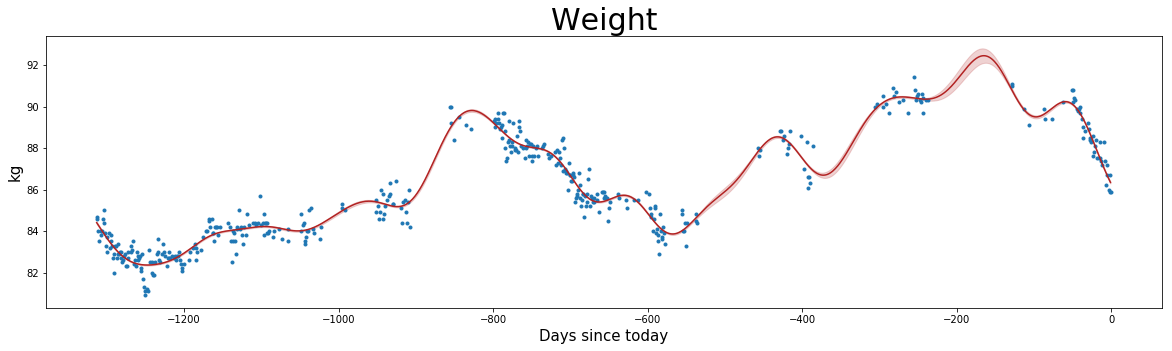

In [196]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

ax.plot(data['date_num'], data['kg'], '.')
ax.plot(to_plot['date'], to_plot['prediction'], color='firebrick')

ax.fill_between(to_plot['date'], to_plot['prediction'] - np.sqrt(np.diag(y_cov)), 
                                    to_plot['prediction'] + np.sqrt(np.diag(y_cov)),  color='firebrick', alpha=0.2)

ax.set_title('Weight', size=30)
ax.set_ylabel('kg', size=15)
ax.set_xlabel('Days since today', size=15)